**Importing necessary libraries**

In [16]:
import pandas as pd
import numpy as np
import os
import cv2

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.utils import np_utils
from keras.layers import Input,AveragePooling2D,Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler,ModelCheckpoint,EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

**Preprocessing and splitting data**

In [2]:
conv_images,labels=[],[]
def img_resize(data_directory):
    categories=os.listdir(data_directory)
    
    for category in categories:        
        images_folder=os.path.join(data_directory,category)
        given_images=os.listdir(images_folder)              
        
        for image_name in given_images:
            image_path=os.path.join(images_folder,image_name) 
            resized=load_img(image_path,target_size=(224,224)) 
            image_array = img_to_array(resized)
            image_array  = preprocess_input(image_array)
            conv_images.append(image_array)

            if category=='without_mask':
                labels.append(0)               
            elif category=='with_mask':
                labels.append(1)      
        
    return np.array(conv_images,dtype="float32"),np.array(labels)            

In [3]:
data,labels=img_resize("./images")
labels=np_utils.to_categorical(labels)

In [4]:
X_train,X_test,Y_train,Y_test=train_test_split(data,labels,test_size=0.25)

**Viewing augmented images**

In [5]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        horizontal_flip=True,
        zoom_range=0.1,
        width_shift_range=0.1, 
        height_shift_range=0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

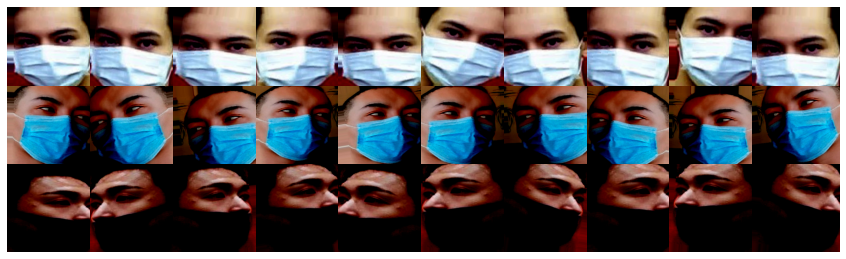

In [6]:
X_train3 = X_train[9,].reshape((1,224,224,3))
Y_train3 = Y_train[9,].reshape((1,2))
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    X_train2, Y_train2 = datagen.flow(X_train3,Y_train3).next()
    plt.imshow(X_train2[0].reshape((224,224,3)))
    plt.axis('off')
    if i==9: X_train3 = X_train[12,].reshape((1,224,224,3))
    if i==19: X_train3 = X_train[18,].reshape((1,224,224,3))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

**Plots**

In [22]:
def accuracy_plot(model):
    plt.figure(figsize=(15,5))
    plt.plot(model.history['val_accuracy'],'r',label='validation accuracy')
    plt.plot(model.history['accuracy'],'b',label='train accuracy')   
    plt.ylabel('accuracy')
    plt.xlabel('epoch')  
    plt.legend(loc="lower left")
    axes = plt.gca()
    axes.set_ylim([0.90,1])
    plt.show()

In [8]:
def loss_plot(model):
    plt.figure(figsize=(15,5))
    plt.plot(model.history['val_loss'],'r',label='validation loss')
    plt.plot(model.history['loss'],'b',label='train loss')   
    plt.ylabel('loss')
    plt.xlabel('epoch')  
    plt.legend(loc="lower left")
    plt.show()

# Imagenet

**Initializing callback parameter**

In [11]:
callbacks1 = [ 
    EarlyStopping(monitor = 'loss', patience = 7), 
    ReduceLROnPlateau(monitor = 'loss', patience = 4), 
    ModelCheckpoint('./best-imagenet', save_best_only=True) # saving the best model
]

**Load imagenet with FC layer off**

In [12]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

**Constructing FC layer**

In [17]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.4)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

**Base model followed by head model(FC layer) -> complete model**

In [18]:
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])

**Fitting on augmented images**

In [19]:
history= model.fit(datagen.flow(X_train,Y_train, batch_size=64),validation_data=(X_test, Y_test),epochs=10,callbacks=callbacks1)

Epoch 1/10
46/46 [==============================] - ETA: 0s - loss: 0.1746 - accuracy: 0.9397WARNING:tensorflow:From /home/sree/.local/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./best-imagenet/assets
46/46 [==============================] - 83s 2s/step - loss: 0.1746 - accuracy: 0.9397 - val_loss: 0.0488 - val_accuracy: 0.9823 - lr: 0.0010
Epoch 2/10
46/46 [==============================] - 74s 2s/step - loss: 0.0307 - accuracy: 0.9889 - val_loss: 0.0389 - val_accuracy: 0.9865 - lr: 0.0010
Epoch 3/10
46/46 [==============================] - 60s 1s/step - loss: 0.0227 - accuracy: 0.9931 - val_loss: 0.1009 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/10
46/46 [===================

In [20]:
model.save('./imagenet.hdf5')

**Plotting accuracy and loss**

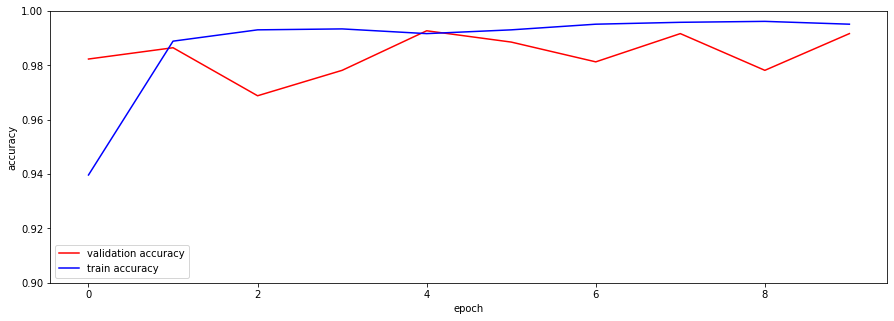

In [23]:
accuracy_plot(history)

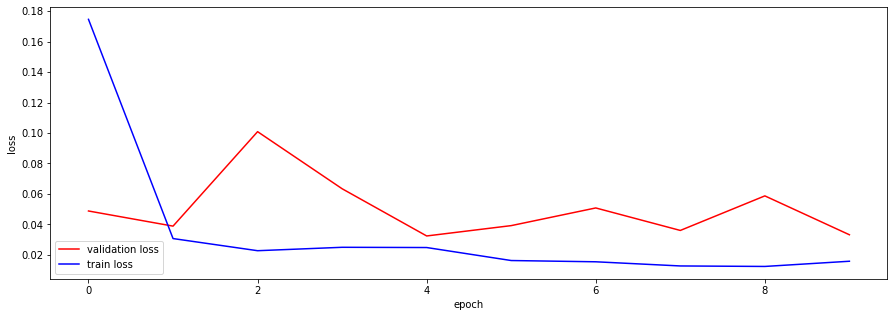

In [24]:
loss_plot(history)